Data for the fingerprints depending on latitud and longitud

In [2]:
function get_fingerprints()

    fp_dir = joinpath(@__DIR__, "..", "data")
    isdir(fp_dir) || mkpath(fp_dir)
    fp_file = joinpath(fp_dir, "FINGERPRINTS_SLANGEN_Bakker.nc")
    if !isfile(fp_file)
        url = "https://github.com/scrim-network/BRICK/raw/master/fingerprints/FINGERPRINTS_SLANGEN_Bakker.nc"
        download(url, fp_file)
    end

    fplat = ncread(fp_file,"lat")
    fplon = ncread(fp_file,"lon")
    fpAIS = ncread(fp_file,"AIS")
    fpGSIC = ncread(fp_file,"GLAC")
    fpGIS = ncread(fp_file,"GIS")
    ncclose()

    return fplat,fplon,fpAIS,fpGSIC,fpGIS
end

get_fingerprints (generic function with 1 method)

Segments selected Manzanillo,Colima : lat 19.1138 lon -104.3385
                  New Orlands: lat 29.9511 lon -90.0715

Code to obtain the components of global sea level rise

In [110]:
import Pkg 

In [114]:
Pkg.add("CSV")

In [125]:
using DataFrames
using CSV
Brickcomps = CSV.File("/Users/ce3304/Downloads/projections_MAP_RCP85_sneasybrick.csv") |> DataFrame

Row,YEAR,GMSL,LWS,GLAC,GIS,AIS,TE,TEMP,OCHEAT,CO2,OCEANCO2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?
1,1850.0,-0.102153,0.000325643,-0.0307438,0.00305963,-0.0489542,0.00727428,-0.181525,-18.8794,279.192,0.740886
2,1851.0,-0.0684015,0.000326355,-0.0272493,0.00290103,-0.042466,0.00766773,-0.0688389,-5.6435,278.942,-2.30122
3,1852.0,-0.0955456,0.000264489,-0.030078,0.00243201,-0.0412545,0.00804689,-0.156925,-34.7849,279.874,-1.57303
4,1853.0,-0.0599957,-1.31477e-5,-0.0251425,0.00275303,-0.0407208,0.00840254,-0.114708,-30.7725,282.065,-1.06167
5,1854.0,-0.0836821,0.000269126,-0.0264085,0.00268931,-0.0407323,0.00872585,0.227197,-21.4257,282.073,-1.00631
6,1855.0,-0.0115779,0.000469725,-0.0253438,0.0025343,-0.0409695,0.00890898,-0.0987867,-29.2714,282.778,0.836196
7,1856.0,-0.0800312,0.000438501,-0.0273048,0.00248161,-0.039903,0.00859525,-0.0233152,-23.576,282.104,-0.84116
8,1857.0,-0.0835417,0.000261133,-0.0264662,0.00237941,-0.0406448,0.00773374,-0.337109,-42.0525,282.789,0.454979
9,1858.0,-0.0649237,0.000713304,-0.0258677,0.0028196,-0.0400596,0.0070105,-0.217046,-47.2591,282.447,0.641629


Vectors of all values for (btime,AIS,GSIC,GIS,TE,LWS,GMSL)

In [150]:
btime=Brickcomps[:,1];
GMSL=Brickcomps[:,2];
LWS=Brickcomps[:,3];
GIS= Brickcomps[:,5];
GSIC=Brickcomps[:,4];
TE=Brickcomps[:,7];
AIS=Brickcomps[:,6];


Tuple for brickcomps

In [148]:
brickcomps=Tuple([btime,AIS,GSIC,GIS,TE,LWS,GMSL]);

Downscale function in steps

In [200]:
ensInds=[1];
lonlat= ([-104.3385,19.1138],[-90.0715,29.9511]);
ystart=2010;
yend=2200;
tstep=10;

In [201]:
   # To do - check with vectors of lat, lon
   (fplat,fplon,fpAIS,fpGSIC,fpGIS) = get_fingerprints()
   (btime,AIS,GSIC,GIS,TE,LWS,GMSL) = brickcomps

   # Select indices of time of interest, with respect to timestep
   tinds = findall(x -> x .>= ystart && x .<=yend, btime)
   years = collect(ystart:yend)
   yinds = findall(x -> x % tstep==0, years)
    # Need to normalize LSL relative to 2000
    inorm = findall(x -> x==2000, btime)

    tdim=length(btime)

    if length(years)==length(tinds)
        tinds = tinds[yinds]
    else
        println("Error: years outside of bounds")
        return nothing
    end
    num_ens = length(ensInds)

    # Output matrix: ens x time x segment
    lsl_out = zeros(num_ens, length(tinds), length(lonlat))

    # Trim component vectors to timesteps and ensembles. Assume interval is 1 year
    if tdim==size(AIS)[1] # check that time dimension is 1
        # for normalizing
        AIS_norm = AIS[inorm,ensInds]
        GSIC_norm = GSIC[inorm,ensInds]
        GIS_norm = GIS[inorm,ensInds]
        TE_norm = TE[inorm,ensInds]
        LWS_norm = LWS[inorm,ensInds]
        GMSL_norm = GMSL[inorm,ensInds]
        # actual projections
        AIS = AIS[tinds,ensInds]
        GSIC = GSIC[tinds,ensInds]
        GIS = GIS[tinds,ensInds]
        TE = TE[tinds,ensInds]
        LWS = LWS[tinds,ensInds]
        GMSL = GMSL[tinds,ensInds]
    else
        println("Error: time dimension is not 1 for brick components")
        return nothing
    end

20×1 Matrix{Float64}:
 0.07959805235043593
 0.1232602781760524
 0.16262683792738608
 0.24971348350116676
 0.37531359801273045
 0.6278969273267964
 0.8783901147961274
 1.1964052062593713
 1.54594185107609
 1.925847652805639
 2.359219751930589
 2.7972278010862706
 3.2682781077824274
 3.7773633456799667
 4.294849144684612
 4.808167760163779
 5.3385380941267035
 5.882951615252544
 6.414091728020897
 6.9509200046559245

In [192]:
function subtractor(minval,maxval)
    function y(point,n)
        if point - n < minval
            return min(maxval,point - n + maxval)
        else
            return point - n
        end
    end
end



subtractor (generic function with 1 method)

In [193]:
function adder(maxval)
    function y(point,n)
        if point + n > maxval
            return point + n - maxval
        else
            return point + n
        end
    end
end

adder (generic function with 1 method)

In [194]:
lon_subtractor = subtractor(1,360)
lon_adder = adder(360)
lat_adder = adder(180)
lat_subtractor = subtractor(1,180)


(::var"#y#149"{Int64, Int64}) (generic function with 1 method)

In [195]:
using Statistics

In [202]:

    for f in 1:length(lonlat) # Loop through lonlat tuples

        lon = lonlat[f][1]
        lat = lonlat[f][2]
        # Convert Longitude to degrees East
        # CIAM Lat is already in (-90,90) by default
        if lon <0
            lon = lon + 360
        end

        # Find fingerprint degrees nearest to lat,lon
        ilat = findall(isequal(minimum(abs.(fplat.-lat))),abs.(fplat.-lat))
        ilon = findall(isequal(minimum(abs.(fplon.-lon))),abs.(fplon.-lon))


        # Take average of closest lat/lon values
        fpAIS_flat = collect(skipmissing(Iterators.flatten(fpAIS[ilon,ilat])))
        fpGSIC_flat = collect(skipmissing(Iterators.flatten(fpGSIC[ilon,ilat])))
        fpGIS_flat = collect(skipmissing(Iterators.flatten(fpGIS[ilon,ilat])))

        fpAIS_loc = mean(fpAIS_flat[isnan.(fpAIS_flat).==false],dims=1)[1]
        fpGSIC_loc = mean(fpGSIC_flat[isnan.(fpGSIC_flat).==false],dims=1)[1]
        fpGIS_loc = mean(fpGIS_flat[isnan.(fpGIS_flat).==false],dims=1)[1]
        fpTE_loc = 1.0
        fpLWS_loc=1.0
        # Keep searching nearby lat/lon values if fingerprint value is NaN unless limit is hit
        inc =1

        while isnan(fpAIS_loc) || isnan(fpGIS_loc) || isnan(fpGSIC_loc) && inc<5

            newlonStart = lon_subtractor.(fplon[ilon],inc)[1]
            newlatStart = lat_subtractor.(fplat[ilat],inc)[1]
            newlonEnd = lon_adder.(fplon[ilon],inc)[1]
            newlatEnd = lat_adder.(fplat[ilat],inc)[1]

            latInd1 = minimum(findall(isequal(minimum(abs.(fplat.-newlatStart))),abs.(fplat.-newlatStart)))
            #minimum(findall(x-> x in newlatStart,fplat))
            latInd2 = maximum(findall(isequal(minimum(abs.(fplat.-newlatEnd))),abs.(fplat.-newlatEnd)))
            #maximum(findall(x -> x in newlatEnd,fplat))

            lonInd1 = minimum(findall(isequal(minimum(abs.(fplon.-newlonStart))),abs.(fplon.-newlonStart)))
            #minimum(findall(x-> x in newlonStart,fplon))
            lonInd2 = maximum(findall(isequal(minimum(abs.(fplon.-newlonEnd))),abs.(fplon.-newlonEnd)))
            #maximum(findall(x -> x in newlonEnd,fplon))

            if latInd2 < latInd1
                latInds=[latInd1; 1:latInd2]
            else
                latInds=latInd1:latInd2
            end
            if lonInd2 < lonInd1
                lonInds=[lonInd1; 1:lonInd2]
            else
                lonInds = lonInd1:lonInd2
            end

            fpAIS_flat = collect(skipmissing(Iterators.flatten(fpAIS[lonInds,latInds])))
            fpGSIC_flat = collect(skipmissing(Iterators.flatten(fpGSIC[lonInds,latInds])))
            fpGIS_flat = collect(skipmissing(Iterators.flatten(fpGIS[lonInds,latInds])))

            fpAIS_loc = mean(fpAIS_flat[isnan.(fpAIS_flat).==false],dims=1)[1]
            fpGSIC_loc = mean(fpGSIC_flat[isnan.(fpGSIC_flat).==false],dims=1)[1]
            fpGIS_loc = mean(fpGIS_flat[isnan.(fpGIS_flat).==false],dims=1)[1]

            inc = inc + 1

        end

        # If still NaN, throw an error
        if isnan(fpAIS_loc) || isnan(fpGIS_loc) || isnan(fpGSIC_loc)
            println("Error: no fingerprints found for ($(lon),$(lat))")
            return nothing
        end
      # Multiply fingerprints by BRICK ensemble members
      if ndims(AIS) > 1
        for n in 1:size(AIS)[2] # loop through ensemble members
            lsl_out[n, :, f] = fpGIS_loc * GIS[:,n] + fpAIS_loc * AIS[:,n] + fpGSIC_loc * GSIC[:,n] +
                               fpTE_loc * TE[:,n] + fpLWS_loc * LWS[:,n]
            # CIAM - LSL should be sea-level change relative to year 2000
            lsl_norm = fpGIS_loc * GIS_norm[n] + fpAIS_loc * AIS_norm[n] + fpGSIC_loc * GSIC_norm[n] +
                       fpTE_loc * TE_norm[n] + fpLWS_loc * LWS_norm[n]
            lsl_out[n, :, f] = lsl_out[n, :, f] .- lsl_norm
        end
    else
        lsl_out[1, :, f] = fpGIS_loc * GIS[:] + fpAIS_loc * AIS[:] + fpGSIC_loc * GSIC[:] +
            fpTE_loc * TE[:] + fpLWS_loc * LWS[:]
        # CIAM - LSL should be sea-level change relative to year 2000
        lsl_norm = fpGIS_loc * GIS_norm + fpAIS_loc * AIS_norm + fpGSIC_loc * GSIC_norm +
                   fpTE_loc * TE_norm + fpLWS_loc * LWS_norm
        lsl_out[1, :, f] = lsl_out[1, :, f] .- lsl_norm
    end

end # End lonlat tuple


In [203]:
return lsl_out,GMSL

([0.03120418096665055 0.07522986221276362 … 6.666020097337096 7.214959513501805]

[0.0293067056178863 0.07036783108858127 … 5.9698851397342025 6.457385760500493], [0.07959805235043593; 0.1232602781760524; … ; 6.414091728020897; 6.9509200046559245])

Construct new lslr

In [223]:
new_lslr=zeros(20,2);
for j in 1:2
    for i in 1:20
        new_lslr[i,j]=lsl_out[1,i,j];
    end 
end 

Run CIAM with the local SLR
CIAM SSP1

In [208]:
using MimiCIAM
m1 = MimiCIAM.get_model(initfile ="./ColimaUSA1_init.csv")
run(m1)

Update parameter lslr

In [224]:
using Mimi
update_param!(m1, :slrcost, :lslr, new_lslr)
run(m1)

In [225]:
NAC1Col=m1[:slrcost,:NoAdaptCost][:,1];
NAC1USA=m1[:slrcost,:NoAdaptCost][:,2];
OC1Col=m1[:slrcost,:OptimalCost][:,1];
OC1USA=m1[:slrcost,:OptimalCost][:,2];

CIAM with SSP2

In [226]:
using MimiCIAM
m2 = MimiCIAM.get_model(initfile ="./ColimaUSA2_init.csv")
update_param!(m2, :slrcost, :lslr, new_lslr)
run(m2)

In [227]:
NAC2Col=m2[:slrcost,:NoAdaptCost][:,1];
NAC2USA=m2[:slrcost,:NoAdaptCost][:,2];
OC2Col=m2[:slrcost,:OptimalCost][:,1];
OC2USA=m2[:slrcost,:OptimalCost][:,2];

CIAM with SSP3

In [228]:
using MimiCIAM
m3 = MimiCIAM.get_model(initfile ="./ColimaUSA3_init.csv")
update_param!(m3, :slrcost, :lslr, new_lslr)
run(m3)

In [229]:
NAC3Col=m3[:slrcost,:NoAdaptCost][:,1];
NAC3USA=m3[:slrcost,:NoAdaptCost][:,2];
OC3Col=m3[:slrcost,:OptimalCost][:,1];
OC3USA=m3[:slrcost,:OptimalCost][:,2];

CIAM with SSP4

In [230]:
using MimiCIAM
m4 = MimiCIAM.get_model(initfile ="./ColimaUSA4_init.csv")
update_param!(m4, :slrcost, :lslr, new_lslr)
run(m4)

In [231]:
NAC4Col=m4[:slrcost,:NoAdaptCost][:,1];
NAC4USA=m4[:slrcost,:NoAdaptCost][:,2];
OC4Col=m4[:slrcost,:OptimalCost][:,1];
OC4USA=m4[:slrcost,:OptimalCost][:,2];

CIAM with SPP5

In [232]:
using MimiCIAM
m5 = MimiCIAM.get_model(initfile ="./ColimaUSA5_init.csv")
update_param!(m5, :slrcost, :lslr, new_lslr)
run(m5)

In [233]:
NAC5Col=m5[:slrcost,:NoAdaptCost][:,1];
NAC5USA=m5[:slrcost,:NoAdaptCost][:,2];
OC5Col=m5[:slrcost,:OptimalCost][:,1];
OC5USA=m5[:slrcost,:OptimalCost][:,2];

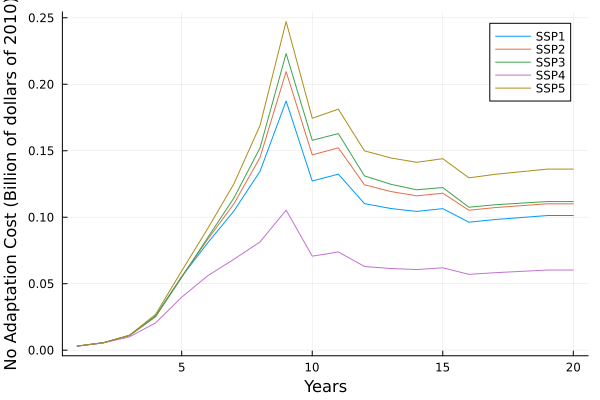

In [239]:
using Plots 
plot(NAC1Col,label="SSP1")
plot!(NAC2Col,label="SSP2")
plot!(NAC3Col,label="SSP3")
plot!(NAC4Col,label="SSP4")
plot!(NAC5Col,label="SSP5")
xlabel!("Years")
ylabel!("No Adaptation Cost (Billion of dollars of 2010)")


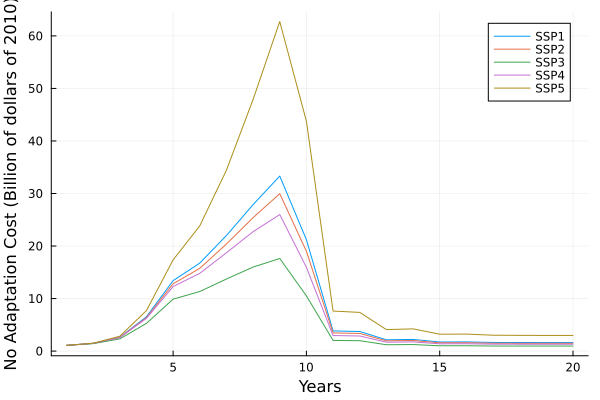

In [235]:
using Plots 
plot(NAC1USA,label="SSP1")
plot!(NAC2USA,label="SSP2")
plot!(NAC3USA,label="SSP3")
plot!(NAC4USA,label="SSP4")
plot!(NAC5USA,label="SSP5")
xlabel!("Years")
ylabel!("No Adaptation Cost (Billion of dollars of 2010)")

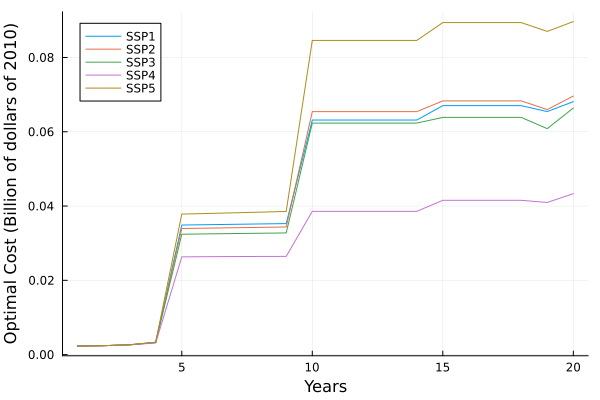

In [236]:
using Plots 
plot(OC1Col,label="SSP1")
plot!(OC2Col,label="SSP2")
plot!(OC3Col,label="SSP3")
plot!(OC4Col,label="SSP4")
plot!(OC5Col,label="SSP5")
xlabel!("Years")
ylabel!("Optimal Cost (Billion of dollars of 2010)")

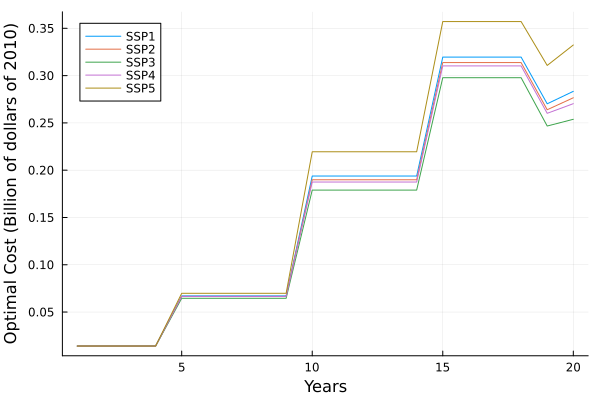

In [237]:
using Plots 
plot(OC1USA,label="SSP1")
plot!(OC2USA,label="SSP2")
plot!(OC3USA,label="SSP3")
plot!(OC4USA,label="SSP4")
plot!(OC5USA,label="SSP5")
xlabel!("Years")
ylabel!("Optimal Cost (Billion of dollars of 2010)")